In [1]:
import resource
from PIRATE_Utils import *
from PyPDF2 import PdfMerger
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

rcParams = {'font.size': 20 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

def Filter_Seq_Description(desc, keywords, delim):
    desc = desc.lower()
    desc_arr = desc.split(delim)
    for d in desc_arr:
        for k in keywords:
            if k in d:
                return 1
    return 0

def Get_Contig(name):
    x = name.split('_')
    return "_".join(x[:-1])

def Get_Sample(name):
    return name.split('.')[0]



In [2]:
cluster_path = '/Users/harihara/Mount/Motif-Analysis/Data/PIRATE-clustering/PIRATE.clusters'
df_clusters = pd.read_csv(cluster_path, sep = "\t")
df_clusters['Sample'] = df_clusters['Contig'].apply(Get_Sample)
df_clusters_summary = df_clusters.groupby(['Cluster_ID']).agg({'Contig':'nunique','Sample':'nunique'})
df_clusters = df_clusters.set_index('Contig')

In [3]:
Eggnog_Annotations = '/Users/harihara/Mount/Motif-Analysis/Data/PIRATE-clustering/EggNOG/PIRATE.eggnog.out.emapper.annotations'
df_EggNOG = pd.read_csv(Eggnog_Annotations, sep = "\t")
df_EggNOG['Contig'] = df_EggNOG['#query'].apply(Get_Contig)

filters = ['phage', 'bacteriophage', 'prophage', 'integrase', 'virus', 'capsid', 'viru', 'tail', 'endonuclease']
df_EggNOG['Phage-Indicator'] = df_EggNOG['Description'].apply(Filter_Seq_Description, keywords = filters, delim = " ")
df_EggNOG['Phage-PFAM'] = df_EggNOG['PFAMs'].apply(Filter_Seq_Description, keywords = filters, delim = ",")
df_EggNOG = df_EggNOG[['#query','Contig','Phage-Indicator','Preferred_name','COG_category','Description', 'Phage-PFAM']]


In [4]:
EggNOG_Hits = '/Users/harihara/Mount/Motif-Analysis/Data/PIRATE-clustering/EggNOG/PIRATE.eggnog.out.emapper.seed_orthologs'

df_Eggnog_Seed_Orthologs = pd.read_csv(EggNOG_Hits, sep = "\t")
df_Eggnog_Seed_Orthologs = df_Eggnog_Seed_Orthologs[['#qseqid', 'qstart', 'qend']]
df_Eggnog_Seed_Orthologs = df_Eggnog_Seed_Orthologs.rename(columns = {'qstart':'e_qstart', 'qend':'e_qend', '#qseqid':'#query'})
df_EggNOG = df_EggNOG.merge(df_Eggnog_Seed_Orthologs, on = '#query', how = 'left')

In [5]:
df_phage = df_EggNOG[(df_EggNOG['Phage-Indicator']==1)].copy()
df_phage = df_phage.set_index('Contig').join(df_clusters, how = 'left')
df_phage = df_phage.dropna()
clusters_phage = sorted(df_phage['Cluster_ID'].unique())

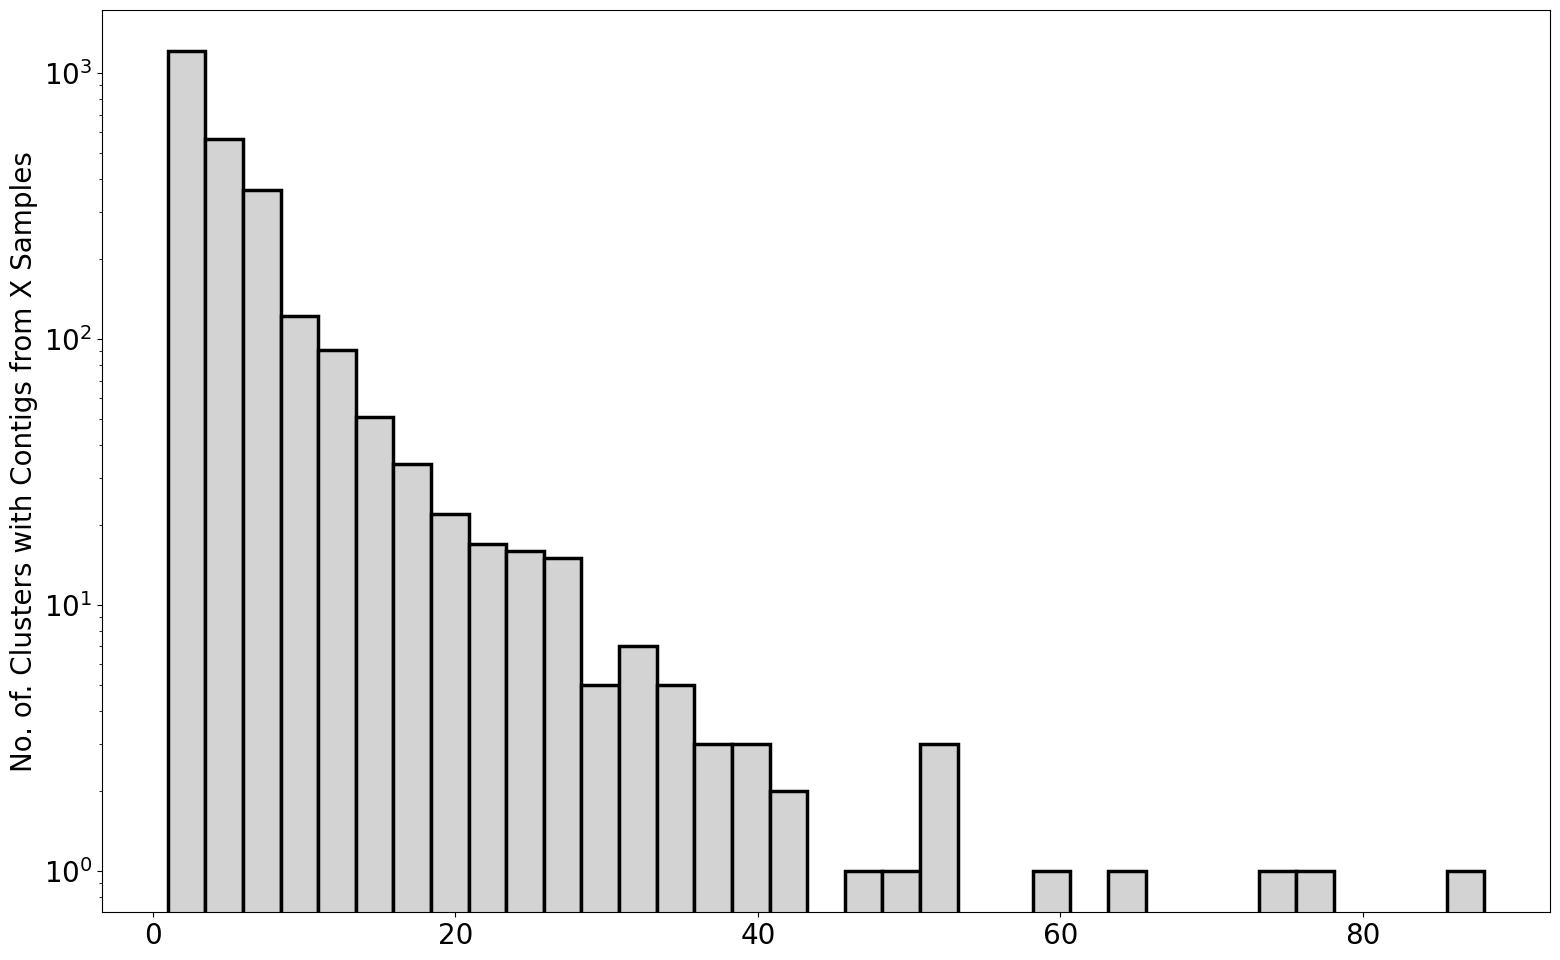

In [6]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
df_clusters_summary.loc[clusters_phage, 'Sample'].plot(kind = 'hist', bins = 35, color = 'lightgray', legend = False, 
                                                       edgecolor='black', linewidth=2.5,ax = ax)
ax.set_yscale('log', base = 10)
ax.set_ylabel('No. of. Clusters with Contigs from X Samples')
fig.tight_layout()

In [7]:

T = df_EggNOG[(df_EggNOG['Phage-Indicator']==1)].copy()
T = T.set_index('Contig').join(df_clusters, how = 'right')
T = T.reset_index()
T['Description'] = T['Description'].fillna("-")

In [8]:
out_dir = '/Users/harihara/Research-Activities/Plots/Motif_Statistics/Motifs_Paper_Plots/PIRATE-Gene-Plots/'
if not isdir(out_dir):
    mkdir(out_dir)

for i in range(len(clusters_phage)):
    c = clusters_phage[i]
    fig, lgd = Plot_Genes(T[T['Cluster_ID']==c], str('Cluster:'+str(int(c))))
    fig.savefig(out_dir+'Cluster-'+str(int(c))+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.close('all')
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


In [12]:
pdfs = listdir(out_dir)
pdfs.sort()
merger = PdfMerger()
for pdf in pdfs:
    if pdf.startswith('Cluster'):
        try:
            merger.append(out_dir+pdf)
        except FileNotFoundError:
            print(pdf, 'not found')
        
merger.write(out_dir+'/PIRATE-Clusters.pdf')
merger.close()